# Predicting Newsletter Subscription from Minecraft Gameplay Behavior
DSCI 100 – Group 11 Final Report


## Introduction


#### Background

Newsletters are commonly used in games to share updates and community information.
Some players choose to subscribe while others do not, and this difference may relate to player characteristics.
Our goal was to explore whether simple demographic information could help explain subscription behaviour.

#### Research Questions

`Broad Question`: 

What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

`Specific Question`: 

Can Age and Experience predict subscription rate?

#### Dataset
The `player.csv`  dataset contains information describing the users. It is contains 196 observations (users) and 7 variables about them. 
<br>Those variables are:
- `experience` -- character, level of experience ("Pro", "Veteran", "Regular", "Amateur", "Beginner")
- `subscribe` -- logical, whether the user is subscribed to the blog
- `hashedEmail` -- character, hashed form of user email
- `played_hours` -- double, total time in hours a user has been on the server
- `name` -- character, user's name
- `gender` -- character, user's gender
- `Age` -- double, user's age.

Table 1.1:
| Variable | Type | Meaning |  |
|---|---|---|---|
experience | chr | experience level of player | "Pro", "Veteran", "Regular", "Amateur", "Beginner" |
subscribe | lgl| player is subscribed to newsletter or not | TRUE or FALSE |
hashedEmail | chr | player email as identifier | hashed for anonymity
played_hours | dbl | total hours played in game |
name | chr | player name |
gender | chr | player gender | Male, Female, Non-binary, Two-Spirited, Agender, Other, Prefer not to say |
Age | dbl | player age | 9 - 58 |

In [5]:
library(tidyverse)
library(tidymodels)
library(themis)
library(cowplot)

In [3]:
player_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/players.csv")
session_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/sessions.csv")

player_data <- player_data |>
filter(Age != is.na(Age)) |>
mutate(subscribe = as.factor(subscribe),
       experience = as.factor(experience))


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Players.csv Summary

In [9]:
player_data_age_hours <- select(player_data,played_hours, Age)

player_data_numeric_summaries <- 
    bind_cols(summary = c("Mean","Minimum","Maximum", "Standard Deviation", "Mode",
                          "1st Quartile", "2nd Quartile", "3rd Quartile"),
              bind_rows(map_df(player_data_age_hours, mean, na.rm = TRUE), #mean
                        map_df(player_data_age_hours, range, na.rm = TRUE), #min + max
                        map_df(player_data_age_hours, sd, na.rm = TRUE), #std dev
                        
                        bind_cols(played_hours = group_by(player_data_age_hours, played_hours) |>  #mode
                                          summarize(count = n()) |>slice_max(count) |> pull(played_hours), 
                                  Age = group_by(player_data_age_hours, Age) |> summarize(count = n()) |>
                                          slice_max(count) |> pull(Age)),
                        tibble(played_hours = quantile(pull(player_data_age_hours,played_hours), #quartiles
                                                       c(0.25, 0.5, 0.75), na.rm = TRUE),
                               Age = quantile(pull(player_data_age_hours,Age), 
                                              c(0.25, 0.5, 0.75), na.rm = TRUE)))) |>
    mutate(across(played_hours:Age, round, 2)) #rounding

player_data_numeric_summaries

summary,played_hours,Age
<chr>,<dbl>,<dbl>
Mean,5.9,21.14
Minimum,0.0,9.00
Maximum,223.1,58.00
Standard Deviation,28.5,7.39
Mode,0.0,17.00
1st Quartile,0.0,17.00
2nd Quartile,0.1,19.00
3rd Quartile,0.6,22.75


In [7]:
player_data_category <- select(player_data, experience, subscribe, gender)

experience_summary <- player_data_category |> group_by(experience) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))
subscribe_summary <- player_data_category |> group_by(subscribe) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2))                      
gender_summary <- player_data_category |> group_by(gender) |> summarize(number = n()) |> arrange(-number) |>
                                mutate(percent_total = round(number/nrow(player_data_category)*100,2)) 

experience_summary
subscribe_summary
gender_summary

experience,number,percent_total
<fct>,<int>,<dbl>
Amateur,63,32.47
Veteran,48,24.74
Beginner,35,18.04
Regular,35,18.04
Pro,13,6.70


subscribe,number,percent_total
<fct>,<int>,<dbl>
TRUE,142,73.2
FALSE,52,26.8


gender,number,percent_total
<chr>,<int>,<dbl>
Male,124,63.92
Female,37,19.07
Non-binary,15,7.73
Prefer not to say,11,5.67
Two-Spirited,5,2.58
Agender,2,1.03


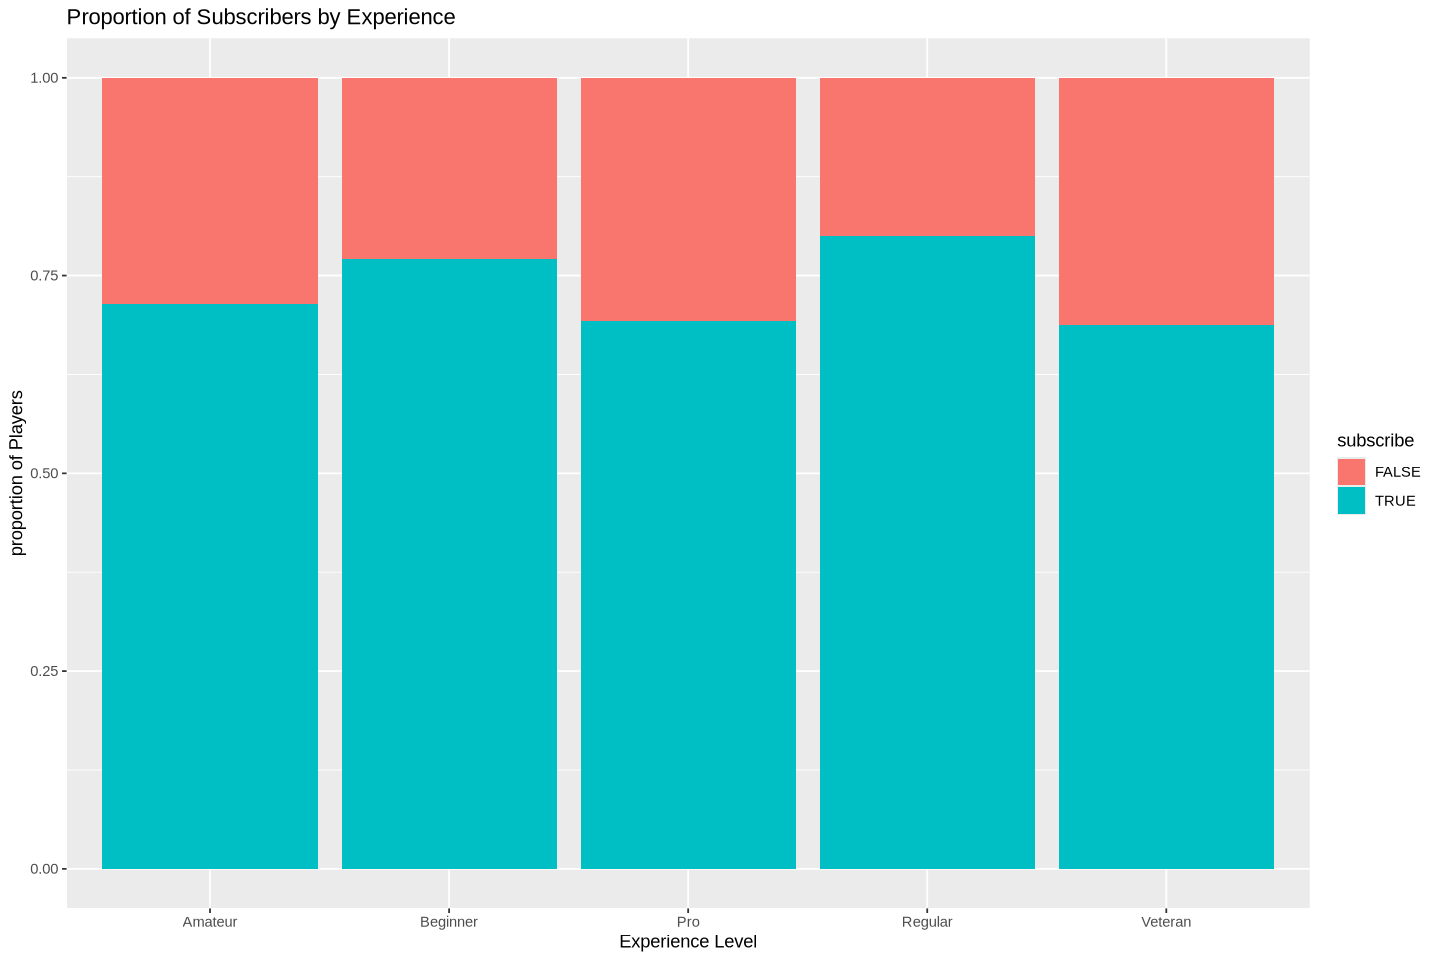

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribers by Experience", x = "Experience Level", y = "proportion of Players")

### Summary Table

In [27]:
summary_table <- player_data |>
  summarize(
    n_players = n(),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    subscribe_rate = sum(subscribe == "TRUE") / n(),
    mean_hours_sub = mean(played_hours[subscribe == TRUE], na.rm = TRUE),
    mean_hours_nosub = mean(played_hours[subscribe == FALSE], na.rm = TRUE))
summary_table

n_players,mean_age,median_age,subscribe_rate,mean_hours_sub,mean_hours_nosub
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.13918,19,0.7319588,7.883099,0.5019231


#### Age vs Subscription

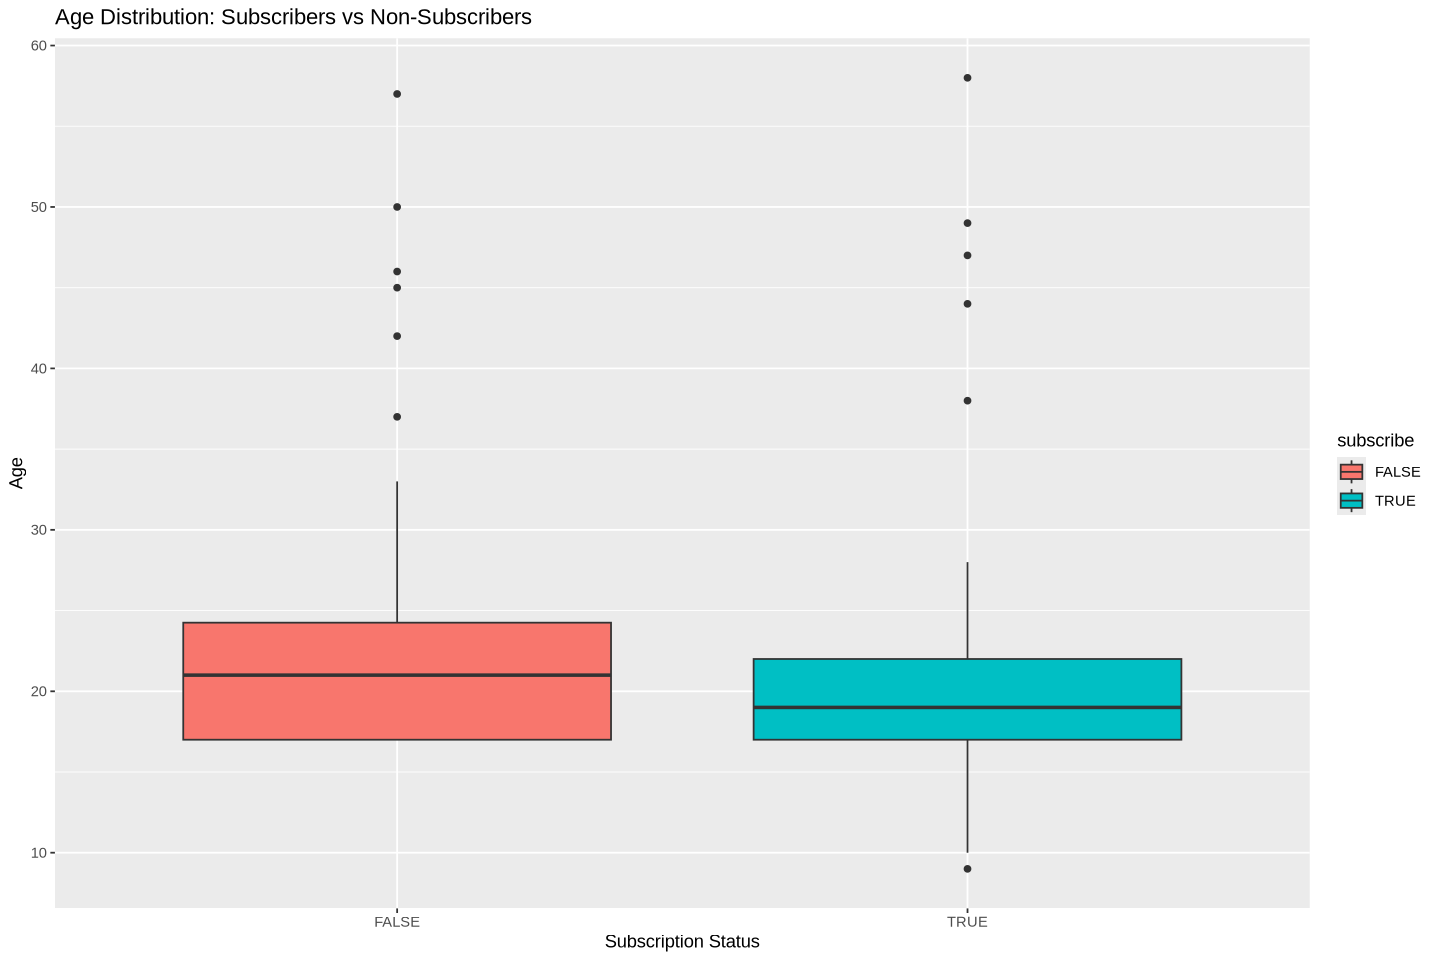

In [28]:
ggplot(player_data, aes(x = subscribe, y = Age, fill = subscribe)) +
  geom_boxplot() +
  labs(title = "Age Distribution: Subscribers vs Non-Subscribers",
       x = "Subscription Status",
       y = "Age")

### Experience vs Subscription — Count Plot

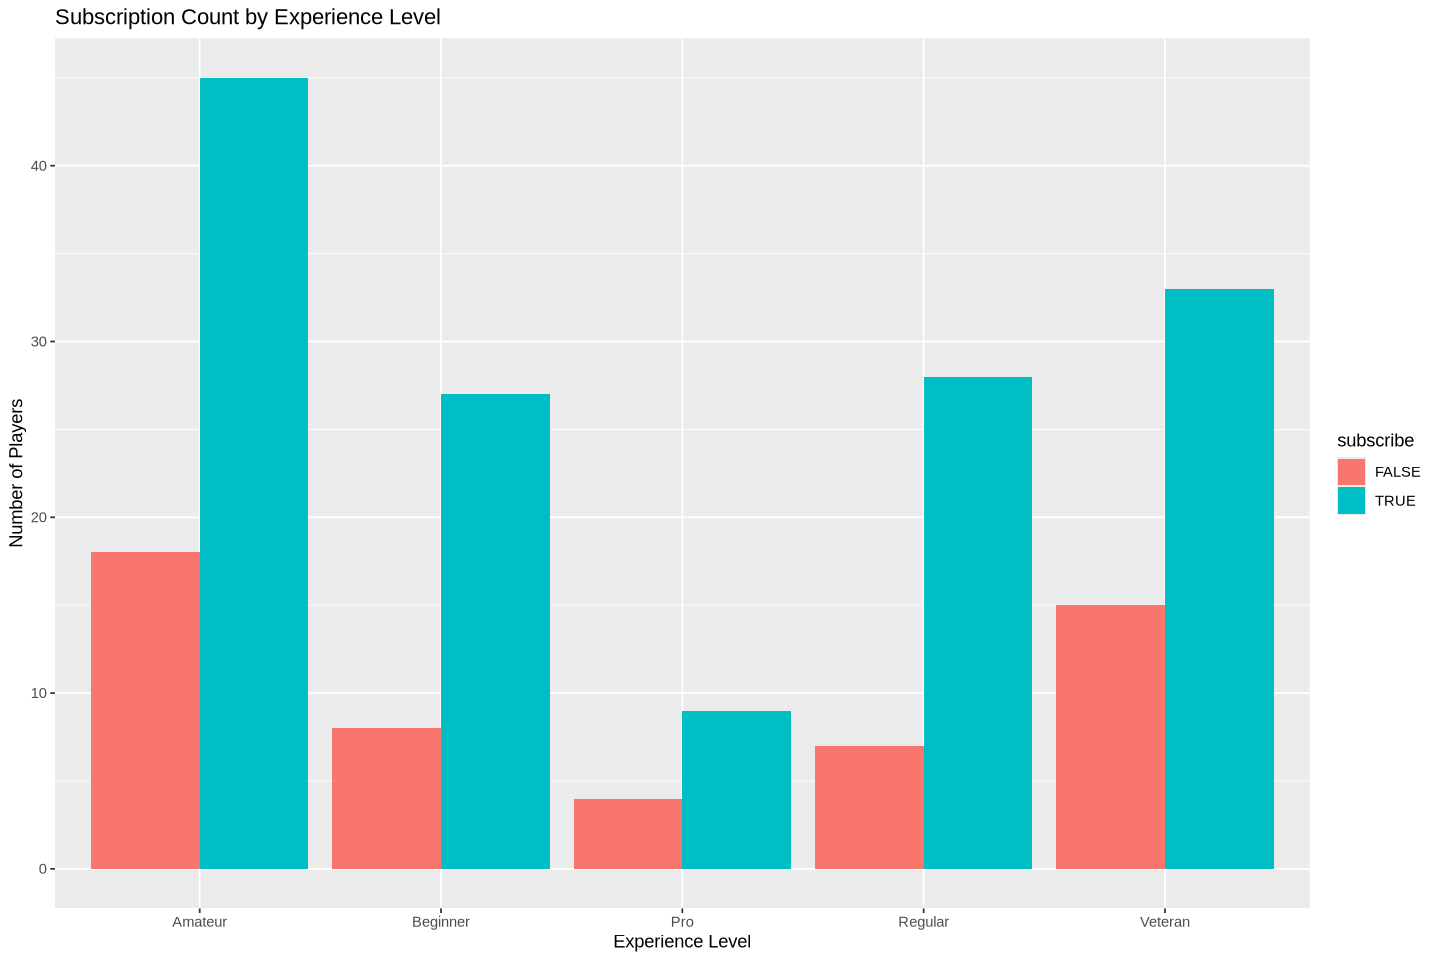

In [30]:
ggplot(player_data, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(title = "Subscription Count by Experience Level",
       x = "Experience Level",
       y = "Number of Players")

#### Split and 5-fold Data Separation

In [4]:
set.seed(1)
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

#### K-NN Classification Models

In [5]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 3))

# manual forward selection
knn_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
                step_normalize(all_predictors())

knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train)

knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train) |>
                step_normalize(Age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

age_tune <- workflow() |>
            add_recipe(knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

experience_tune <- workflow() |>
            add_recipe(knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

both_tune <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

#### K-NN Tune Model Plots

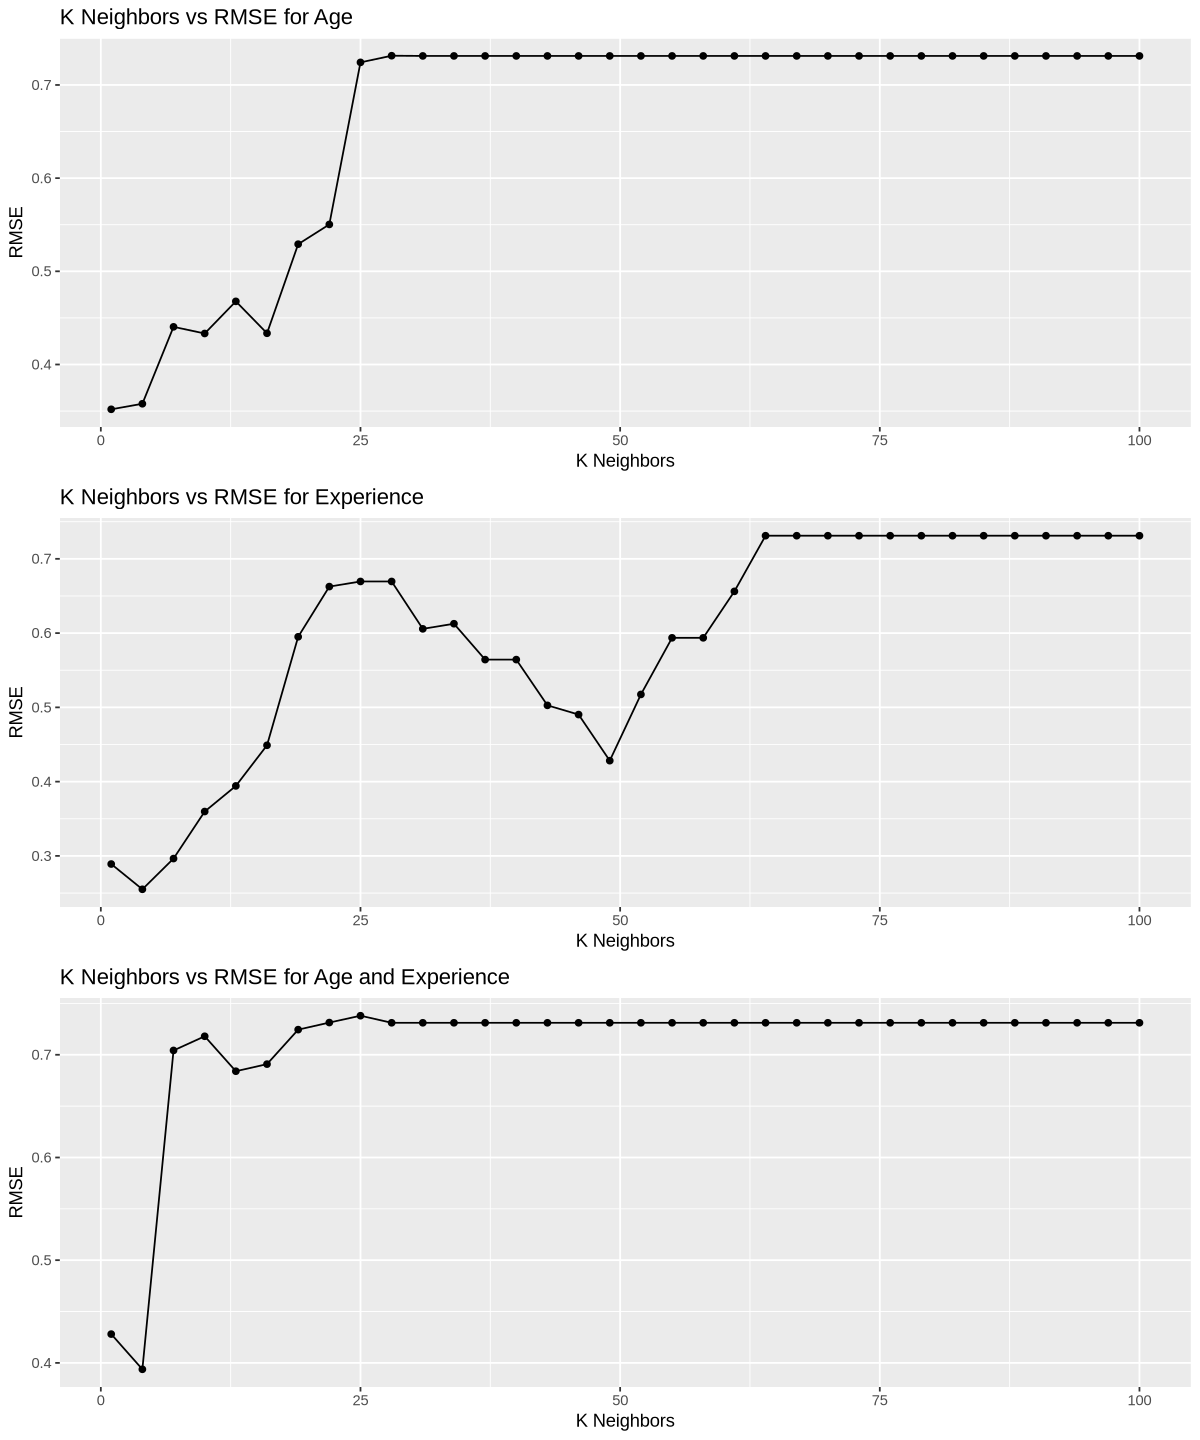

In [6]:
options(repr.plot.width = 10, repr.plot.height = 12)
age_tune_plot <- age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Age")

experience_tune_plot <- experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Experience")

both_tune_plot <- both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Age and Experience")

plot_grid(age_tune_plot,
          experience_tune_plot,
          both_tune_plot, ncol = 1)


#### Select Predictors and K Value

In [7]:
max_age_rmse <- age_tune |> 
                slice_max(mean)
max_experience_rmse <- experience_tune |>
                        slice_max(mean)
max_both_rmse <- both_tune |>
                    slice_max(mean)
# max_age_rmse        # <- max rmse = 0.7313793 @ 28 neighbors
# max_experience_rmse # <- max rmse = 0.7311494 @ 64-100 neighbors
# max_both_rmse       # <- max rmse = 0.738046 @ 25 neighbors

#### K-NN Model and Prediction

In [8]:
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec_tuned) |>
            fit(player_train)


player_predict <- predict(knn_fit, player_test) |>
                bind_cols(player_test)


#### Confusion Matrix and Metrics

In [9]:
prediction_conf_mat <- player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)

prediction_accuracy <- player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")

prediction_precision <- player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_recall <- player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

prediction_conf_mat
bind_rows(prediction_accuracy, prediction_precision, prediction_recall)

          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857
precision,binary,0.7291667
recall,binary,0.9722222


From the above confusion matrix, it can be seen that `TRUE` was predicted 48 out of 49 times, leading to an RMSPE of 0.714. However, of the 49 predictions, only 35 where correct, and `False` was never predicted correctly; making this model worse than predicting `TRUE` for every observation regardless of `Age` and `experience`. The bias to only predicting `True` is most likely due to the imbalance of `TRUE` and `FALSE` values in `subscribe`, which can be addressed through upsampling.

#### Upsample Training Data and 5-fold Data Separation

In [10]:
set.seed(1)
player_train_upsampled <- recipe(subscribe ~ Age + experience, data = player_train) |>
                            step_upsample(subscribe, over_ratio = 1, skip = TRUE) |>
                             prep(retain = TRUE) |>
                             bake(new_data = NULL)

player_vfold_upsampled <- vfold_cv(player_train_upsampled, v = 5, strata = subscribe)

#### Upsampled K-NN Models

In [11]:
balanced_knn_recipe_age <- recipe(subscribe ~ Age, data = player_train_upsampled) |>
                            step_normalize(all_predictors())

balanced_knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train_upsampled)

balanced_knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train_upsampled) |>
                            step_normalize(Age)


balanced_age_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_experience_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

balanced_both_tune <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold_upsampled, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 


#### K-NN Tune Model Plots of Upsampled

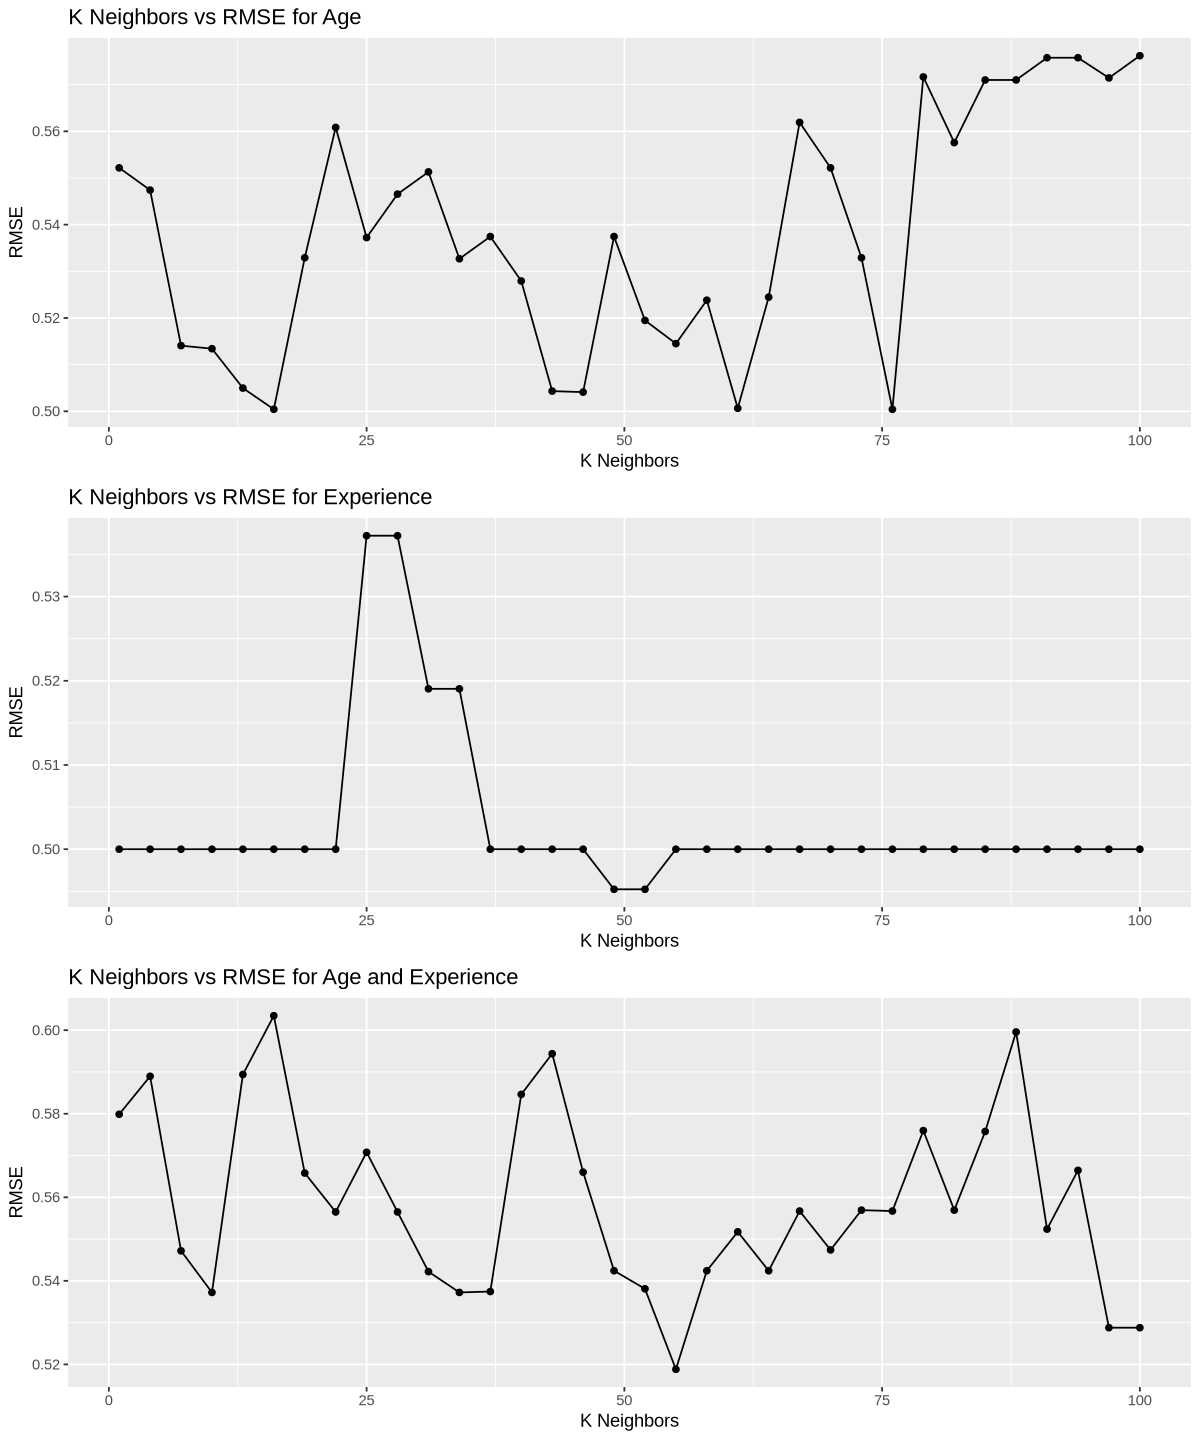

In [12]:
options(repr.plot.width = 10, repr.plot.height = 12)
balanced_age_tune_plot <- balanced_age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Age")

balanced_experience_tune_plot <- balanced_experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Experience")

balanced_both_tune_plot <- balanced_both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbors vs RMSE for Age and Experience")

plot_grid(balanced_age_tune_plot,
          balanced_experience_tune_plot,
          balanced_both_tune_plot, ncol = 1)

#### Select Predictors and K Value of Upsampled

In [13]:
balanced_max_age_rmse <- balanced_age_tune |> 
                slice_max(mean)
balanced_max_experience_rmse <- balanced_experience_tune |>
                        slice_max(mean)
balanced_max_both_rmse <- balanced_both_tune |>
                    slice_max(mean)
# balanced_max_age_rmse        # <- max rmse = 0.5761905 @ 28 neighbors
# balanced_max_experience_rmse # <- max rmse = 0.5372294 @ 25-28 neighbors
# balanced_max_both_rmse       # <- max rmse = 0.6034632 @ 25 neighbors

#### Upsampled K-NN Model and Prediction

In [14]:
balanced_knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) |>
                set_engine("kknn") |>
                set_mode("classification")

balanced_knn_fit <- workflow() |>
            add_recipe(balanced_knn_recipe_both) |>
            add_model(balanced_knn_spec_tuned) |>
            fit(player_train_upsampled)

balanced_player_predict <- predict(balanced_knn_fit, player_test) |>
                bind_cols(player_test)


#### Confusion Matrix and Metrics of Upsampled Model

In [15]:
balanced_prediction_conf_mat <- balanced_player_predict |>
                        conf_mat(truth = subscribe, estimate = .pred_class)

balanced_prediction_accuracy <- balanced_player_predict |>
                        metrics(truth = subscribe, estimate = .pred_class) |>
                        filter(.metric == "accuracy")

balanced_prediction_precision <- balanced_player_predict |> # TRUE is the second event level
                        precision(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_recall <- balanced_player_predict |>
                        recall(truth = subscribe, estimate = .pred_class, event_level = "second")

balanced_prediction_conf_mat
bind_rows(balanced_prediction_accuracy, balanced_prediction_precision, balanced_prediction_recall)

          Truth
Prediction FALSE TRUE
     FALSE    10   24
     TRUE      3   12

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4489796
precision,binary,0.8000000
recall,binary,0.3333333


After upsampling to create a balance between `TRUE` and `FALSE` observations, the RMSPE actually becomes worse than the RMSPE of the unbalanced model. This is likely due to ... or the nature of the upsampling technique does not upsample the data in a way that in condusive to retaining the original relationships.